### Firstly, we import all the necessary packages

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

import keras
from keras import optimizers
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasRegressor



Using TensorFlow backend.


### Loading the dataset

In [196]:
df = pd.read_csv('lego_Sets.csv')

### Removing variables that would give no predictive power (information variables such as ID's or descriptions)

In [197]:
df = df.drop(['prod_desc', 
              'prod_id', 
              'prod_long_desc', 
              'set_name'],
             axis=1)

### Changing variables into right format

In [198]:
df.list_price = df.list_price.astype(float)
df['review_difficulty'] = df['review_difficulty'].astype("category")
df['review_difficulty'] = df['review_difficulty'].cat.reorder_categories(['Very Easy',
                                                               'Easy',
                                                               'Average',
                                                               'Challenging',
                                                               'Very Challenging'],
                                                                        ordered = True)
df['review_difficulty'] = df['review_difficulty'].cat.codes
df.theme_name = df.theme_name.astype(object)
df.ages = df.ages.astype(object)

### Next, we are checking for missing values within the dataset

In [199]:
missing_data = pd.DataFrame({'Number of occurencies': df.isna().sum(),
                             'Percentage': 100*df.isna().sum()/len(df)
                            })
missing_data[missing_data['Number of occurencies'] > 0]

,Number of occurencies,Percentage
num_reviews,1620,13.212625
play_star_rating,1775,14.476796
star_rating,1620,13.212625
theme_name,3,0.024468
val_star_rating,1795,14.639915


Since the missings in star_rating (all 3 columns concerning them) are common for certain observations, maybe we can somehow reduce the number of them by filling missing values with computed value.

Missings in review difficulty are labeled with a group code equal to -1.

We can see that star_rating has less NA's than play and val star_rating. We shall see if there is a correlation between those 3 variables. 

In [200]:
corr = df[['star_rating', 'play_star_rating', 'val_star_rating']].corr()
corr.style.background_gradient(cmap='coolwarm')

,star_rating,play_star_rating,val_star_rating
star_rating,1,0.608193,0.72789
play_star_rating,0.608193,1,0.480938
val_star_rating,0.72789,0.480938,1


Let us compute means of ratios between star_rating for the whole dataset and use that ratio to create values to impute instead of NA's.

Afterwards, because of slightly high correlation we decided to omit star_rating and leave the two other ratings (and since they all have same number of NA's)

In [201]:
df['star/play'] = df['star_rating']/df['play_star_rating']
df['star/val'] = df['star_rating']/df['val_star_rating']

star_p_mean = df['star/play'].mean()
star_v_mean = df['star/val'].mean()

df.loc[(df['play_star_rating'].isnull()) & (df['star_rating'].notna()), "play_star_rating"] = df["star_rating"]*star_p_mean
df.loc[(df['val_star_rating'].isnull()) & (df['star_rating'].notna()), "val_star_rating"] = df["star_rating"]*star_v_mean

df.drop(['star/play', 'star/val', 'star_rating'], axis=1, inplace=True)

That way we managed to narrow our total rows with NA's to 1620. Unfortunately there is no way to safely replace values for these observations (which all have at least 3 NA's) so we will omit them in further analysis.

In [202]:
df.loc[df.isnull().sum(1)>=3].index

df = df.dropna()

### Checking for categorical variables - whether we can use one hot encoding or will it produce too many new columns

In [213]:
cat_vars = []
cont_vars = []
for variable in df.columns:
    if df[variable].dtype==object:
        cat_vars.append(variable)
    else:
        cont_vars.append(variable)
        
num_of_cats = {}
for category in cat_cols:
    num_of_cats[category] = len(list(df[category].unique()))
    
print(num_of_cats)

{'ages': 31, 'review_difficulty': 6, 'theme_name': 38, 'country': 21}


We can see that all the variables have a lot of levels, let's see how different are the numbers of observations within each level on barplots below.

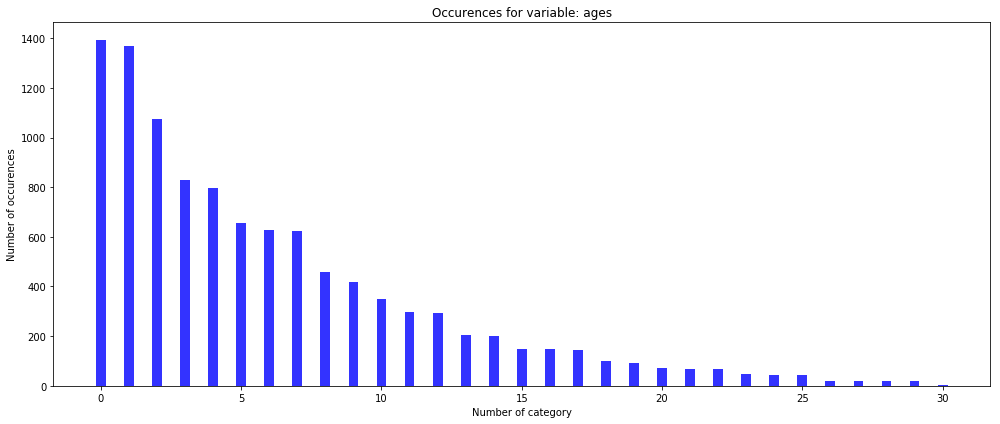

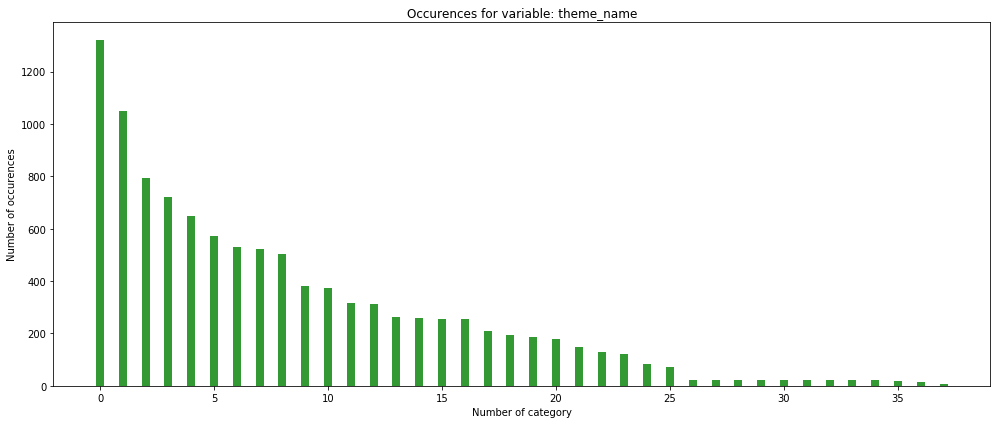

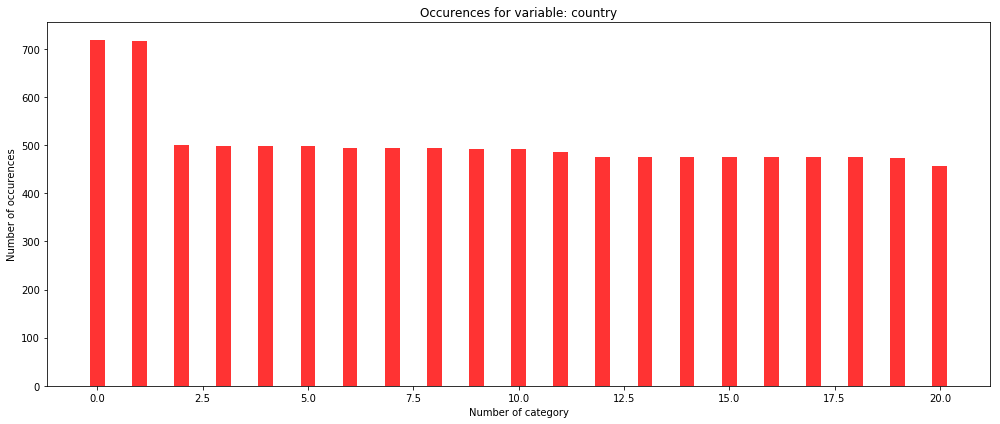

In [275]:
bar_width = 0.35
opacity = 0.8
colors = ["b","g","r"]


for idx, var in enumerate(cat_vars):
    plt.figure(figsize=(14,6))
    boo = list(dict(df[var].value_counts()).values())
    leng = np.arange(len(list(dict(df[var].value_counts()).values())))
    rects = plt.bar(leng, boo, bar_width,
    alpha=opacity,
    color=colors[idx])
    plt.ylabel('Number of occurences')
    plt.xlabel('Number of category')
    plt.title('Occurences for variable: {}'.format(var))
    plt.tight_layout()
    plt.show()

### Creating correlation matrix 

In [206]:
corr = df.drop(['list_price'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm')

,num_reviews,piece_count,play_star_rating,review_difficulty,val_star_rating
num_reviews,1,0.546616,-0.0451145,0.328073,0.0148351
piece_count,0.546616,1,0.0147979,0.509112,0.0636759
play_star_rating,-0.0451145,0.0147979,1,0.018671,0.499167
review_difficulty,0.328073,0.509112,0.018671,1,-0.00300082
val_star_rating,0.0148351,0.0636759,0.499167,-0.00300082,1


There are no visible very high correlations (some ~0.5, but we decided to leave them in further analysis, because these are not worrying values).

### Creating dummy variables through one hot encoding

In [211]:
df2 = pd.get_dummies(df)

### Splitting dataset into training and testing dataset

In [212]:
X, Y = df2.drop(['list_price'], axis=1), df2['list_price']

X_train, X_test, Y_train, Y_test = train_test_split(
                                                    X, 
                                                    Y, 
                                                    test_size=0.3, 
                                                    random_state=361)